#########################

## Example use of xarray/dask/xgcm with CROCO files

    works with or without CURVGRID
    works with or without XIOS
    works with older ROMS ucla/agrif files


- Interpolation to horizontal grids
- Computation of derivatives (relative vorticity)
- Plotting vertical section
- Interpolation on a geopotential level

#########################

Examples adapted from https://github.com/slgentil/croco/blob/master/tutorials/xgcm.ipynb

#########################



In [1]:
import xarray as xr
import numpy as np

#import xroms
from xgcm import Grid

from netCDF4 import Dataset
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Functions to adapt croco outputs to xgcm
##########################################


def adjust_coords(ds):

    if 'nav_lon_rho' not in ds.coords:
        ##########################
        print('for regular CROCO files')
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        print('for XIOS files')
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        
    '''    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])
    '''

    return ds




def add_vertical_coord(ds):
    
    if 'CPP-options' in ds.attrs:
        cpp = 'CPP-options'
    else:
        cpp = 'CPPS'
    
    if 'VertCoordType' in ds.attrs:
        if ds.VertCoordType=='NEW':
            ds['Vtransform'] = 2
        else:
            ds['Vtransform'] = 1
    elif 'NEW_S_COORD' in ds.attrs[cpp]:
        ds['Vtransform'] = 2
    else:
        ds['Vtransform'] = 1

    #####################


    if 'sc_r' not in ds:
        # need to define sc_r for older roms files
        N = ds.s_rho.shape[0]
        ds['sc_r'] = xr.DataArray((np.arange(N) - N +0.5) / N,  dims=["s_rho"])
        ds['sc_w'] = xr.DataArray((np.arange(N+1) - N) / N,  dims=["s_w"])
    else:
        ds['sc_r'] = xr.DataArray(ds.sc_r,  dims=["s_rho"])
        ds['sc_w'] = xr.DataArray(ds.sc_w,  dims=["s_w"])      
        
    ds['Cs_r'] = xr.DataArray(ds.Cs_r,  dims=["s_rho"])
    ds['Cs_w'] = xr.DataArray(ds.Cs_w,  dims=["s_w"]) 
        
        
    '''try:
        ds = ds.reset_coords([c for c in ds.coords if 'Cs' in c])
    except:
        pass'''

    #####################
    # Including vertical coordinates

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.sc_r - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.sc_r + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho; del Zo_rho

    ds.coords['z_rho'] = z_rho

    if ds.Vtransform == 1:
        Zo_w = ds.hc * (ds.sc_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_rho + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_w = (ds.hc * ds.sc_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w; del Zo_w

    ds.coords['z_w'] = z_w
    
    return ds

########################



def _compute_metrics_curvilinear(ds):
    """
    Create a xgcm grid and set it in the dataset as a attribute

    Parameters:
        ds : xarray dataset
    returns:
        ds : xarray dataset with the xgcm  grid
        grid : xgcm grid
    """

    # curvilinear grid
    # Create xgcm grid without any metrics
    coords={'x':{'center':'xi_rho',  'inner':'xi_u'}, 
            'y':{'center':'eta_rho', 'inner':'eta_v'}, 
            'z':{'center':'s_rho',   'outer':'s_w'}}

    grid = Grid(ds, 
              coords=coords,
              boundary='extend')
    
    if 'CPP-options' in ds.attrs:
        cpp = 'CPP-options'
    else:
        cpp = 'CPPS'
    
    if 'SPHERICAL' in ds.attrs[cpp]:

        ##########################
        # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
        ds['lon_u'] = grid.interp(ds.lon_rho,'x')
        ds['lat_u'] = grid.interp(ds.lat_rho,'x')
        ds['lon_v'] = grid.interp(ds.lon_rho,'y')
        ds['lat_v'] = grid.interp(ds.lat_rho,'y')
        ds['lon_psi'] = grid.interp(ds.lon_v,'x')
        ds['lat_psi'] = grid.interp(ds.lat_u,'y')
        _coords = ['lon_u','lat_u','lon_v','lat_v','lon_psi','lat_psi']
        ds = ds.set_coords(_coords)
        

    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['z_u'] = grid.interp(ds.z_rho,'x')
    ds['z_v'] = grid.interp(ds.z_rho,'y')
    _coords = ['z_u','z_v']
    ds = ds.set_coords(_coords)
    

    # add horizontal distance metrics for rho, u, v and psi point
    if 'pm' in ds and 'pn' in ds:
        ds['dx_rho'] = 1/ds['pm']
        ds['dy_rho'] = 1/ds['pn']
        ds['dx_u'] = grid.interp(1/ds['pm'],'x')
        ds['dy_u'] = grid.interp(1/ds['pn'],'x')
        ds['dx_v'] = grid.interp(1/ds['pm'],'y')
        ds['dy_v'] = grid.interp(1/ds['pn'],'y')
        ds['dx_psi'] = grid.interp(grid.interp(1/ds['pm'], 'y'),  'x') 
        ds['dy_psi'] = grid.interp(grid.interp(1/ds['pn'], 'y'),  'x') 
        
    try:
        ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'y'),  'x') 
    except:
        ds['mask_rho'] = ds['pm']*0.+1.
        ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'y'),  'x') 


    '''ds.coords['z_rho'][np.isnan(ds.mask_rho)] = 0.
    ds.coords['z_w'][np.isnan(ds.mask_rho)] = 0.
    ds.coords['z_rho'][ds.mask_rho==0] = 0.
    ds.coords['z_w'][ds.mask_rho==0] = 0.'''
    
    # add vertical metrics for u, v, rho and psi points
    ds['dz_rho'] = grid.diff(ds.z_w,'z')
    ds['dz_w']   = grid.diff(ds.z_rho,'z')
    ds['dz_u']   = grid.interp(ds.dz_rho,'x')
    ds['dz_v']   = grid.interp(ds.dz_rho,'y')
    ds['dz_psi'] = grid.interp(ds.dz_v,'x')

    # add areas metrics for rho,u,v and psi points
    ds['rArho'] = ds.dx_psi * ds.dy_psi
    ds['rAu']   = ds.dx_v   * ds.dy_v
    ds['rAv']   = ds.dx_u   * ds.dy_u
    ds['rApsi'] = ds.dx_rho * ds.dy_rho

    metrics = {
           ('x',): ['dx_rho', 'dx_u', 'dx_v', 'dx_psi'], # X distances
           ('y',): ['dy_rho', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
           ('z',): ['dz_rho', 'dz_u', 'dz_v', 'dz_psi', 'dz_w'], # Z distances
           ('x', 'y'): ['rArho', 'rAu', 'rAv', 'rApsi'] # Areas
          }

    ds.attrs['xgcm-Grid'] = Grid(ds, 
              coords=coords,
              metrics = metrics,
              periodic=False,
              boundary='extend')

    return ds





def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    #ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    

        

# Open the dataset

In [3]:
#hisfile = '/net/libra/local/tmp/1/gula/ROMS/roms_for_ModNum/2122/case_topo/basin_his.nc'

# Example 1: CROCO file without CURVGRID (test case)
hisfile = '/net/libra/local/tmp/1/gula/ROMS/roms_for_ModNum/2122/case_seamount/basin_his.nc'

# Example 2: regular realistic CROCO file 
#hisfile = '/data0/project/meddle/gula/ROMS/Simulations/GIGATL/GIGATL1/gigatl1_1h_tides_region_01_2009-02-01.nc'

# Example 3: XIOS realistic CROCO file 
#hisfile = '/net/omega/local/tmp/1/gula/GIGATL6/GIGATL6_1h_tides/HIS/GIGATL6_5d_aver.mean.2005-2011.nc'
#grdfile = '/net/libra/local/tmp/1//gula/ROMS/Simulations/GIGATL/GIGATL6/gigatl6_grd_masked.nc'

# Example 4: ROMS UCLA file
#hisfile='/net/krypton/data0/project/meddle/gula/ROMS/Simulations/PACBIG/HIS/pacbig_his.0402.nc'
#grdfile='/net/krypton/data0/project/meddle/gula/ROMS/Simulations/PACBIG/pacbig_grd_nw_dig.nc'


#######################

ds = xr.open_dataset(hisfile)
ds = adjust_coords(ds)

########
# Just keep last time-step

ds = ds.isel(time=-1)

#ds

for regular CROCO files


In [4]:
if 'h' not in ds:
    # add static variables from a separate grid file to the dataset
    grd = xr.open_dataset(grdfile)
    grd = adjust_coords(grd)
    ds = add_grd(ds,grd)


########
# Add vertical coordinate (z)
ds = add_vertical_coord(ds)

########
# Add an xgcm Grid instance to the dataset
ds = _compute_metrics_curvilinear(ds)
grid = ds.attrs['xgcm-Grid']

########

if 'lon_rho' in ds:
    xdim = 'lon'; ydim = 'lat'
else:
    xdim = 'x'; ydim = 'y'
   
######## 
    
#ds

# Plot SST

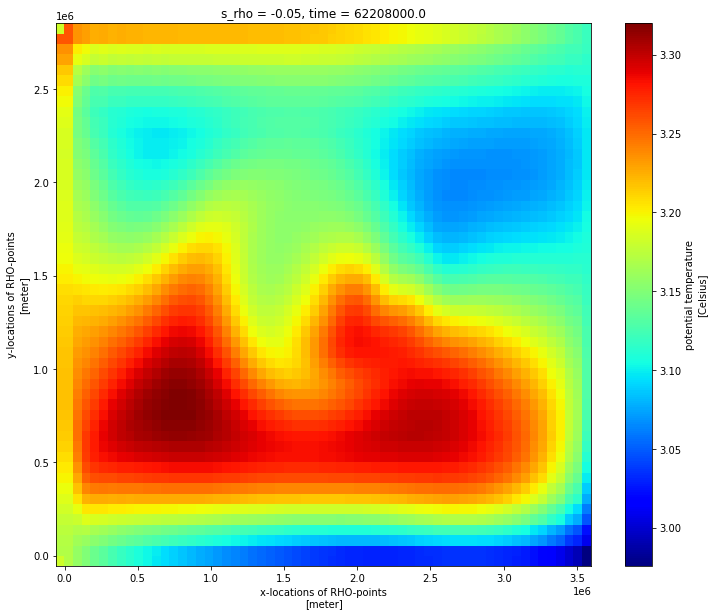

In [5]:
ds.temp.where(ds.mask_rho==1).isel(s_rho=-1,xi_rho=slice(0,-1) ).plot(x=xdim + '_rho',\
                                                                      y=ydim + '_rho',\
                                                                      cmap='jet', figsize=(12,10))


---

## Interpolation to the intermediate grid point : Kinetic energy
\begin{equation}
\frac{1}{2}(u^2 + v^2)
\end{equation}

CPU times: user 59.4 ms, sys: 388 µs, total: 59.8 ms
Wall time: 57.6 ms


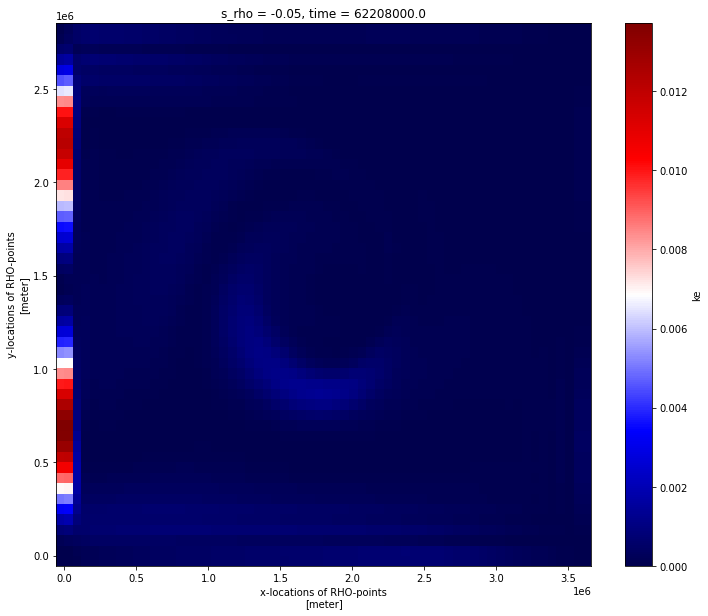

In [6]:
%%time
ds['ke'] = 0.5 * (grid.interp(ds.u**2,'x') + grid.interp(ds.v**2,'y'))

ds.ke.where(ds.mask_rho==1).isel(s_rho=-1).plot(x=xdim + '_rho',\
                                                y=ydim + '_rho',\
                                                cmap='seismic',  figsize=(12,10))


## Plot section on sigma-levels

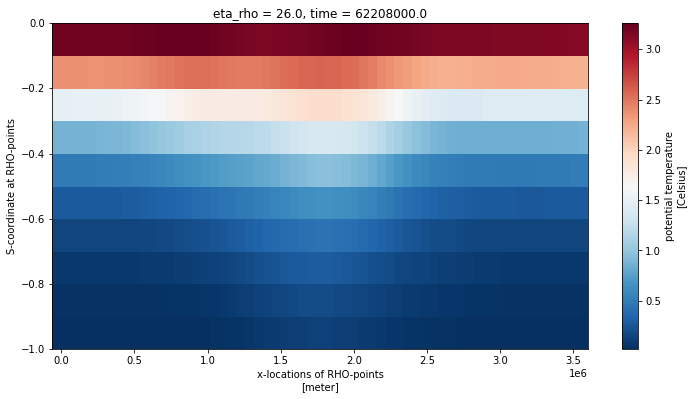

In [7]:

section = ds.temp.isel(eta_rho=np.int(ds.temp.shape[1]/2-1),xi_rho=slice(0,-1))

section.plot(x=xdim + '_rho', y='s_rho',  figsize=(12, 6), cmap = 'RdBu_r')


## Plot section on z-levels

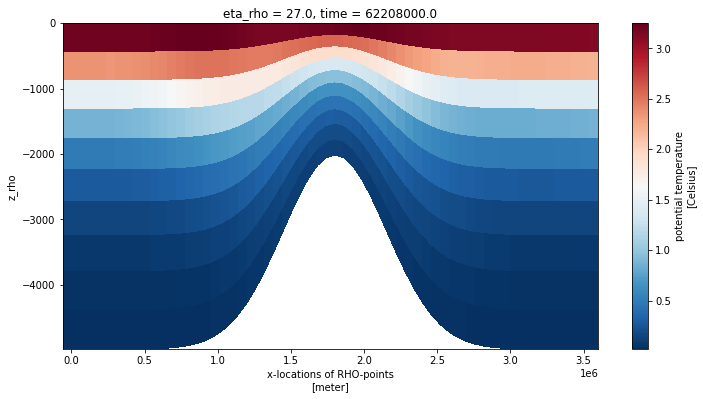

In [8]:


section = ds.temp.isel(eta_rho=np.int(ds.temp.shape[1]/2),xi_rho=slice(0,-1))

section.plot(x=xdim + '_rho', y='z_rho', figsize=(12, 6), cmap = 'RdBu_r')


## Interpolate variable at a constant depth


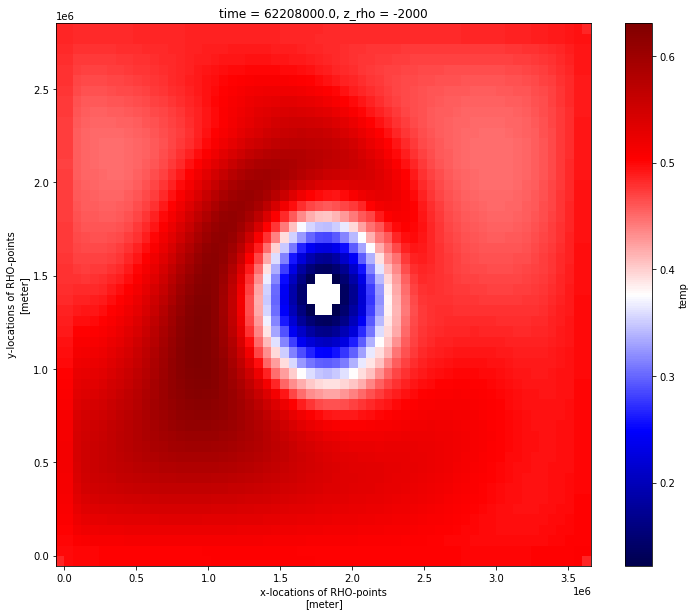

In [10]:

var = grid.transform(ds.temp, 'z', np.array([-2000]), target_data=ds.z_rho).compute()

var.plot(x=xdim + '_rho', y=ydim + '_rho', cmap='seismic', figsize=(12,10))


---

## Derivatives : relative vorticity
\begin{equation}
\xi = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}
\end{equation}

### At the surface 

no interpolation = SSH variations can be neglected

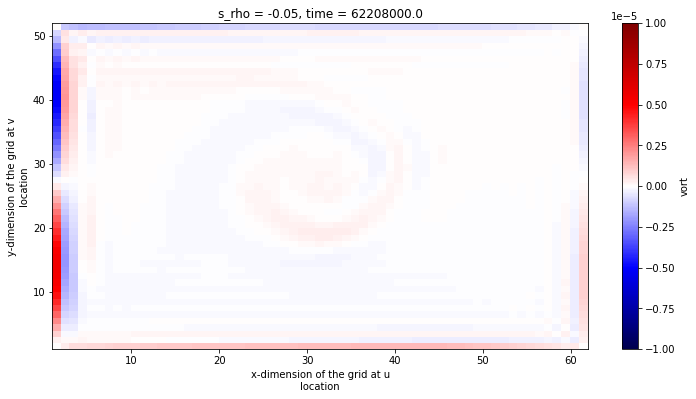

In [11]:
ds['vort'] = (-grid.derivative(ds.u, 'y') + grid.derivative(ds.v, 'x'))

try:
    ds.vort.where(ds.mask_psi==1).isel(s_rho=-1).plot(x=xdim+'_psi', y=ydim+'_psi',\
                                                      vmin=-1e-4, vmax=1e-4, cmap='seismic', figsize=(12,10))
except:
    ds.vort.isel(s_rho=-1).plot(vmin=-1e-5, vmax=1e-5, cmap='seismic', figsize=(12,6))


### At depth

First interpolate velocity fields at constant depth and them compute vorticity

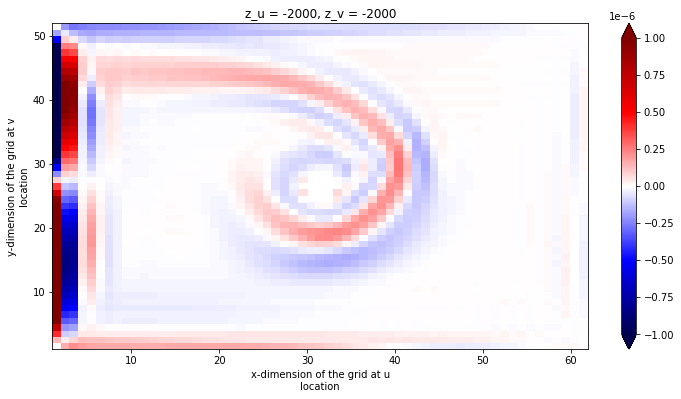

In [12]:
depth = -2000

u_z = grid.transform(ds.u, 'z', np.array([depth]), target_data=ds.z_u).compute()
v_z = grid.transform(ds.v, 'z', np.array([depth]), target_data=ds.z_v).compute()

vort_z = (-grid.derivative(u_z, 'y') + grid.derivative(v_z, 'x')); del u_z,v_z

try:
    vort_z.where(ds.mask_psi==1).plot(x=xdim+'_psi', y=ydim+'_psi',\
                                                 vmin=-1e-5, vmax=1e-5, cmap='seismic', figsize=(12,10))
except:
    vort_z.plot(vmin=-1e-6, vmax=1e-6, cmap='seismic', figsize=(12,6))
    